In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("CH") & contact == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [5]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo'
], axis=1)   # Exclude the identifier from the features

In [6]:
train_data = training_features.drop(['line_drive'], axis=1).copy()
train_label = training_features['line_drive'].copy()
testing_data = testing_features.drop(['line_drive'], axis=1).copy()
testing_label = testing_features['line_drive'].copy()

In [7]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'swing', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [8]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'swing', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [9]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [10]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [11]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.591788072529085
Log Loss: 0.6613517296521003


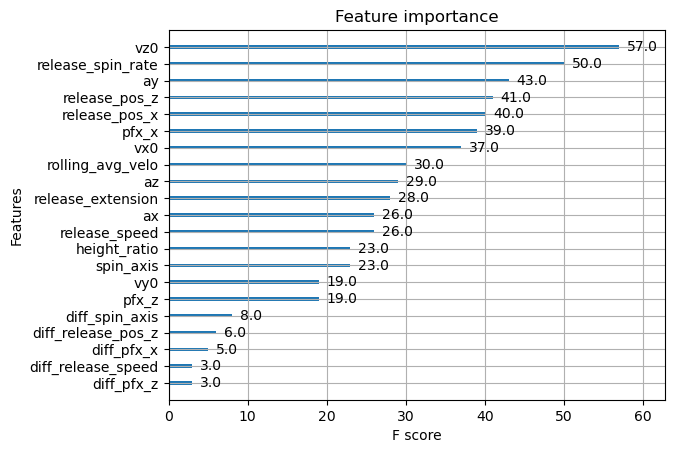

In [12]:
xgb.plot_importance(model)
plt.show()

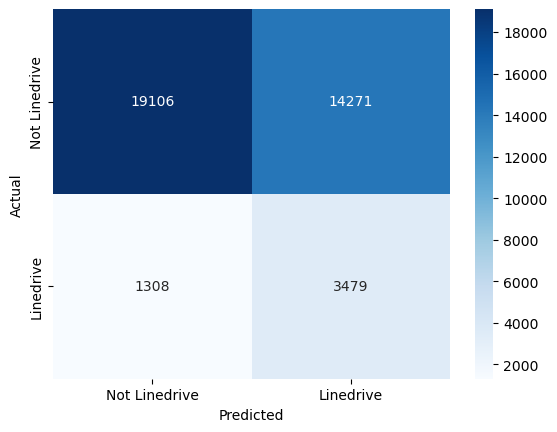

In [13]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [14]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [15]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 11:08:26,968] A new study created in memory with name: no-name-a89ebf38-ad38-446f-a0fe-a93e3f08cd5b


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.66635
[2]	eval-logloss:0.65646
[3]	eval-logloss:0.64870
[4]	eval-logloss:0.64198
[5]	eval-logloss:0.63175
[6]	eval-logloss:0.62124
[7]	eval-logloss:0.61354
[8]	eval-logloss:0.60529
[9]	eval-logloss:0.59869
[10]	eval-logloss:0.59061
[11]	eval-logloss:0.58580
[12]	eval-logloss:0.58130
[13]	eval-logloss:0.57490
[14]	eval-logloss:0.56476
[15]	eval-logloss:0.55891
[16]	eval-logloss:0.55142
[17]	eval-logloss:0.54476
[18]	eval-logloss:0.54298
[19]	eval-logloss:0.53636
[20]	eval-logloss:0.53180
[21]	eval-logloss:0.52799
[22]	eval-logloss:0.52362
[23]	eval-logloss:0.52181
[24]	eval-logloss:0.51755
[25]	eval-logloss:0.51318
[26]	eval-logloss:0.51023
[27]	eval-logloss:0.50448
[28]	eval-logloss:0.49928
[29]	eval-logloss:0.49597
[30]	eval-logloss:0.49199
[31]	eval-logloss:0.49004
[32]	eval-logloss:0.48853
[33]	eval-logloss:0.48374
[34]	eval-logloss:0.48064
[35]	eval-logloss:0.47762
[36]	eval-logloss:0.47242
[37]	eval-logloss:0.46877
[38]	eval-logloss:0.46

[I 2023-11-15 11:08:30,162] Trial 0 finished with value: 0.3075493668564664 and parameters: {'max_depth': 8, 'eta': 0.1534022888293536, 'subsample': 0.7767838428681061, 'colsample_bytree': 0.8741383617129477}. Best is trial 0 with value: 0.3075493668564664.


[0]	eval-logloss:0.67726
[1]	eval-logloss:0.66699
[2]	eval-logloss:0.65566
[3]	eval-logloss:0.64601
[4]	eval-logloss:0.63491
[5]	eval-logloss:0.62267
[6]	eval-logloss:0.61777
[7]	eval-logloss:0.61021
[8]	eval-logloss:0.60512
[9]	eval-logloss:0.59720
[10]	eval-logloss:0.58960
[11]	eval-logloss:0.58594
[12]	eval-logloss:0.57805
[13]	eval-logloss:0.57465
[14]	eval-logloss:0.56957
[15]	eval-logloss:0.56268
[16]	eval-logloss:0.56055
[17]	eval-logloss:0.55621
[18]	eval-logloss:0.54994
[19]	eval-logloss:0.54635
[20]	eval-logloss:0.53547
[21]	eval-logloss:0.53136
[22]	eval-logloss:0.52678
[23]	eval-logloss:0.52273
[24]	eval-logloss:0.51942
[25]	eval-logloss:0.51306
[26]	eval-logloss:0.50799
[27]	eval-logloss:0.50248
[28]	eval-logloss:0.50044
[29]	eval-logloss:0.49642
[30]	eval-logloss:0.49271
[31]	eval-logloss:0.48580
[32]	eval-logloss:0.48301
[33]	eval-logloss:0.47991
[34]	eval-logloss:0.47455
[35]	eval-logloss:0.46911
[36]	eval-logloss:0.46709
[37]	eval-logloss:0.46425
[38]	eval-logloss:0.46

[I 2023-11-15 11:08:32,704] Trial 1 finished with value: 0.28365467691617685 and parameters: {'max_depth': 7, 'eta': 0.2869293164891532, 'subsample': 0.8939779268805654, 'colsample_bytree': 0.6159751551968897}. Best is trial 1 with value: 0.28365467691617685.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68241
[3]	eval-logloss:0.67906
[4]	eval-logloss:0.67685
[5]	eval-logloss:0.67335
[6]	eval-logloss:0.67075
[7]	eval-logloss:0.66851
[8]	eval-logloss:0.66623
[9]	eval-logloss:0.66468
[10]	eval-logloss:0.66241
[11]	eval-logloss:0.66016
[12]	eval-logloss:0.65874
[13]	eval-logloss:0.65774
[14]	eval-logloss:0.65552
[15]	eval-logloss:0.65367
[16]	eval-logloss:0.65136
[17]	eval-logloss:0.64952
[18]	eval-logloss:0.64742
[19]	eval-logloss:0.64589
[20]	eval-logloss:0.64301
[21]	eval-logloss:0.64033
[22]	eval-logloss:0.63884
[23]	eval-logloss:0.63746
[24]	eval-logloss:0.63682
[25]	eval-logloss:0.63465
[26]	eval-logloss:0.63246
[27]	eval-logloss:0.63130
[28]	eval-logloss:0.62939
[29]	eval-logloss:0.62744
[30]	eval-logloss:0.62548
[31]	eval-logloss:0.62424
[32]	eval-logloss:0.62225
[33]	eval-logloss:0.62073
[34]	eval-logloss:0.61991
[35]	eval-logloss:0.61837
[36]	eval-logloss:0.61702
[37]	eval-logloss:0.61548
[38]	eval-logloss:0.61

[I 2023-11-15 11:08:34,867] Trial 2 finished with value: 0.5413764674164463 and parameters: {'max_depth': 6, 'eta': 0.09346039848238354, 'subsample': 0.8091041537321698, 'colsample_bytree': 0.5582654324860443}. Best is trial 1 with value: 0.28365467691617685.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68727
[3]	eval-logloss:0.68561
[4]	eval-logloss:0.68487
[5]	eval-logloss:0.68249
[6]	eval-logloss:0.68098
[7]	eval-logloss:0.68030
[8]	eval-logloss:0.67877
[9]	eval-logloss:0.67844
[10]	eval-logloss:0.67603
[11]	eval-logloss:0.67499
[12]	eval-logloss:0.67456
[13]	eval-logloss:0.67315
[14]	eval-logloss:0.67267
[15]	eval-logloss:0.67183
[16]	eval-logloss:0.66949
[17]	eval-logloss:0.66892
[18]	eval-logloss:0.66817
[19]	eval-logloss:0.66688
[20]	eval-logloss:0.66557
[21]	eval-logloss:0.66510
[22]	eval-logloss:0.66450
[23]	eval-logloss:0.66463
[24]	eval-logloss:0.66424
[25]	eval-logloss:0.66336
[26]	eval-logloss:0.66292
[27]	eval-logloss:0.66150
[28]	eval-logloss:0.66204
[29]	eval-logloss:0.66122
[30]	eval-logloss:0.65903
[31]	eval-logloss:0.65882
[32]	eval-logloss:0.65778
[33]	eval-logloss:0.65547
[34]	eval-logloss:0.65498
[35]	eval-logloss:0.65497
[36]	eval-logloss:0.65444
[37]	eval-logloss:0.65381
[38]	eval-logloss:0.65

[I 2023-11-15 11:08:36,612] Trial 3 finished with value: 0.6119936732990873 and parameters: {'max_depth': 3, 'eta': 0.294468127405237, 'subsample': 0.8040842320118622, 'colsample_bytree': 0.9631964672359858}. Best is trial 1 with value: 0.28365467691617685.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69050
[3]	eval-logloss:0.68962
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68755
[7]	eval-logloss:0.68705
[8]	eval-logloss:0.68610
[9]	eval-logloss:0.68578
[10]	eval-logloss:0.68485
[11]	eval-logloss:0.68409
[12]	eval-logloss:0.68345
[13]	eval-logloss:0.68285
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68247
[16]	eval-logloss:0.68153
[17]	eval-logloss:0.68106
[18]	eval-logloss:0.68084
[19]	eval-logloss:0.68046
[20]	eval-logloss:0.67965
[21]	eval-logloss:0.67890
[22]	eval-logloss:0.67852
[23]	eval-logloss:0.67852
[24]	eval-logloss:0.67813
[25]	eval-logloss:0.67779
[26]	eval-logloss:0.67758
[27]	eval-logloss:0.67697
[28]	eval-logloss:0.67700
[29]	eval-logloss:0.67655
[30]	eval-logloss:0.67561
[31]	eval-logloss:0.67546
[32]	eval-logloss:0.67498
[33]	eval-logloss:0.67436
[34]	eval-logloss:0.67394
[35]	eval-logloss:0.67382
[36]	eval-logloss:0.67368
[37]	eval-logloss:0.67329
[38]	eval-logloss:0.67

[I 2023-11-15 11:08:38,361] Trial 4 finished with value: 0.6534308749131016 and parameters: {'max_depth': 3, 'eta': 0.10610595787775771, 'subsample': 0.7277612573476412, 'colsample_bytree': 0.7069767670283984}. Best is trial 1 with value: 0.28365467691617685.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.68680
[2]	eval-logloss:0.68344
[3]	eval-logloss:0.68113
[4]	eval-logloss:0.67971
[5]	eval-logloss:0.67587
[6]	eval-logloss:0.67393
[7]	eval-logloss:0.67186
[8]	eval-logloss:0.66909
[9]	eval-logloss:0.66839
[10]	eval-logloss:0.66639
[11]	eval-logloss:0.66514
[12]	eval-logloss:0.66368
[13]	eval-logloss:0.66167
[14]	eval-logloss:0.66015
[15]	eval-logloss:0.65821
[16]	eval-logloss:0.65579
[17]	eval-logloss:0.65479
[18]	eval-logloss:0.65284
[19]	eval-logloss:0.65081
[20]	eval-logloss:0.64845
[21]	eval-logloss:0.64648
[22]	eval-logloss:0.64460
[23]	eval-logloss:0.64448
[24]	eval-logloss:0.64344
[25]	eval-logloss:0.64214
[26]	eval-logloss:0.64066
[27]	eval-logloss:0.63910
[28]	eval-logloss:0.63781
[29]	eval-logloss:0.63610
[30]	eval-logloss:0.63412
[31]	eval-logloss:0.63308
[32]	eval-logloss:0.63184
[33]	eval-logloss:0.62928
[34]	eval-logloss:0.62823
[35]	eval-logloss:0.62719
[36]	eval-logloss:0.62658
[37]	eval-logloss:0.62560
[38]	eval-logloss:0.62

[I 2023-11-15 11:08:40,165] Trial 5 finished with value: 0.5560460761072356 and parameters: {'max_depth': 4, 'eta': 0.266211318377946, 'subsample': 0.8097797126656894, 'colsample_bytree': 0.8903215453249957}. Best is trial 1 with value: 0.28365467691617685.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67340
[2]	eval-logloss:0.66543
[3]	eval-logloss:0.65732
[4]	eval-logloss:0.65176
[5]	eval-logloss:0.64245
[6]	eval-logloss:0.63501
[7]	eval-logloss:0.62861
[8]	eval-logloss:0.62416
[9]	eval-logloss:0.61891
[10]	eval-logloss:0.61274
[11]	eval-logloss:0.60918
[12]	eval-logloss:0.60429
[13]	eval-logloss:0.60090
[14]	eval-logloss:0.59794
[15]	eval-logloss:0.59309
[16]	eval-logloss:0.58734
[17]	eval-logloss:0.58243
[18]	eval-logloss:0.57943
[19]	eval-logloss:0.57660
[20]	eval-logloss:0.57006
[21]	eval-logloss:0.56508
[22]	eval-logloss:0.56310
[23]	eval-logloss:0.56054
[24]	eval-logloss:0.55558
[25]	eval-logloss:0.55066
[26]	eval-logloss:0.54409
[27]	eval-logloss:0.53923
[28]	eval-logloss:0.53623
[29]	eval-logloss:0.53379
[30]	eval-logloss:0.52813
[31]	eval-logloss:0.52618
[32]	eval-logloss:0.52240
[33]	eval-logloss:0.51961
[34]	eval-logloss:0.51470
[35]	eval-logloss:0.51088
[36]	eval-logloss:0.50632
[37]	eval-logloss:0.50319
[38]	eval-logloss:0.49

[I 2023-11-15 11:08:42,459] Trial 6 finished with value: 0.35531765494108825 and parameters: {'max_depth': 8, 'eta': 0.12391982524353674, 'subsample': 0.7088748336902385, 'colsample_bytree': 0.5072493571709995}. Best is trial 1 with value: 0.28365467691617685.


[0]	eval-logloss:0.68831
[1]	eval-logloss:0.68427
[2]	eval-logloss:0.68053
[3]	eval-logloss:0.67717
[4]	eval-logloss:0.67448
[5]	eval-logloss:0.67029
[6]	eval-logloss:0.66682
[7]	eval-logloss:0.66446
[8]	eval-logloss:0.66245
[9]	eval-logloss:0.65975
[10]	eval-logloss:0.65729
[11]	eval-logloss:0.65519
[12]	eval-logloss:0.65298
[13]	eval-logloss:0.65161
[14]	eval-logloss:0.64875
[15]	eval-logloss:0.64677
[16]	eval-logloss:0.64479
[17]	eval-logloss:0.64260
[18]	eval-logloss:0.64153
[19]	eval-logloss:0.63915
[20]	eval-logloss:0.63721
[21]	eval-logloss:0.63490
[22]	eval-logloss:0.63263
[23]	eval-logloss:0.63108
[24]	eval-logloss:0.62960
[25]	eval-logloss:0.62766
[26]	eval-logloss:0.62560
[27]	eval-logloss:0.62395
[28]	eval-logloss:0.62125
[29]	eval-logloss:0.62067
[30]	eval-logloss:0.61859
[31]	eval-logloss:0.61690
[32]	eval-logloss:0.61431
[33]	eval-logloss:0.61264
[34]	eval-logloss:0.61075
[35]	eval-logloss:0.60973
[36]	eval-logloss:0.60803
[37]	eval-logloss:0.60568
[38]	eval-logloss:0.60

[I 2023-11-15 11:08:44,338] Trial 7 finished with value: 0.5155589843414647 and parameters: {'max_depth': 6, 'eta': 0.10142936596839836, 'subsample': 0.8238718568574654, 'colsample_bytree': 0.9124767083011476}. Best is trial 1 with value: 0.28365467691617685.


[0]	eval-logloss:0.68247
[1]	eval-logloss:0.67223
[2]	eval-logloss:0.65848
[3]	eval-logloss:0.65184
[4]	eval-logloss:0.64474
[5]	eval-logloss:0.63525
[6]	eval-logloss:0.62725
[7]	eval-logloss:0.62038
[8]	eval-logloss:0.61370
[9]	eval-logloss:0.60799
[10]	eval-logloss:0.60078
[11]	eval-logloss:0.59540
[12]	eval-logloss:0.59065
[13]	eval-logloss:0.58582
[14]	eval-logloss:0.57945
[15]	eval-logloss:0.57403
[16]	eval-logloss:0.56887
[17]	eval-logloss:0.56505
[18]	eval-logloss:0.56072
[19]	eval-logloss:0.55565
[20]	eval-logloss:0.54979
[21]	eval-logloss:0.54459
[22]	eval-logloss:0.54195
[23]	eval-logloss:0.53750
[24]	eval-logloss:0.53175
[25]	eval-logloss:0.52705
[26]	eval-logloss:0.52481
[27]	eval-logloss:0.52005
[28]	eval-logloss:0.51592
[29]	eval-logloss:0.51151
[30]	eval-logloss:0.50766
[31]	eval-logloss:0.50578
[32]	eval-logloss:0.50253
[33]	eval-logloss:0.50053
[34]	eval-logloss:0.49754
[35]	eval-logloss:0.49462
[36]	eval-logloss:0.49144
[37]	eval-logloss:0.48867
[38]	eval-logloss:0.48

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.47103038297970284
Best hyperparameters: {'max_depth': 9, 'eta': 0.29369938725822214, 'subsample': 0.8783275530839444, 'colsample_bytree': 0.9027801704059801}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6035918173168411
Log Loss: 0.6350291879334083


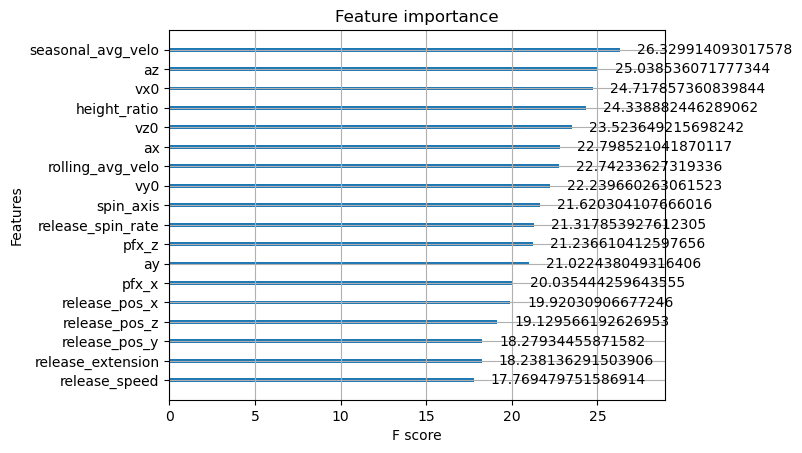

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

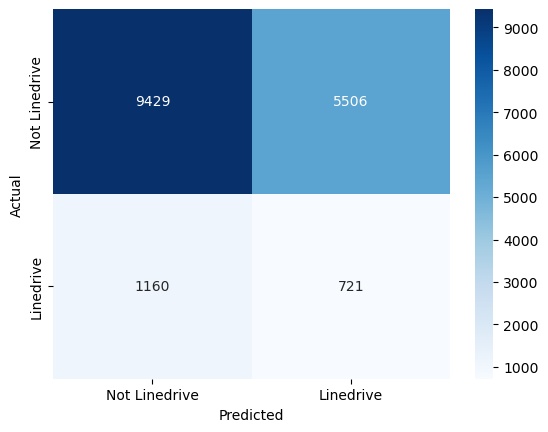

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'swing'],
      dtype='object')

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xld'] = y_pred

In [ ]:
testing_identifiers.head()

,pitch_id_raw,xld
7,661032_543685_543238_1_59_8,0.581926
8,661032_545361_543238_2_57_8,0.493466
9,661032_545361_543238_3_57_8,0.272984
10,661032_543685_543238_4_59_8,0.202081
11,661032_543685_543238_5_59_8,0.457897


In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/ld_2022&3_xld.csv")